In [1]:
import sys 
sys.path.append("../")

In [2]:
from mps_utils import * 
from wave_circuit import * 
import matplotlib.pyplot as plt 
import pickle

In [3]:
import numpy as np
import pymanopt
from pymanopt.manifolds import Product, Stiefel
from pymanopt import Problem
from pymanopt.optimizers import ConjugateGradient, TrustRegions, NelderMead

# Simple optimization on product of Stiefel manifolds
manifold = Product([Stiefel(5, 2), Stiefel(4, 2)])

# Random targets
A1 = np.random.randn(5, 2)
A2 = np.random.randn(4, 2)

@pymanopt.function.autograd(manifold)
def cost(*args):
    X1,X2 = args
    return np.linalg.norm(X1 - A1)**2 + np.linalg.norm(X2 - A2)**2

@pymanopt.function.autograd(manifold)
def euclidean_gradient(*args):
    X1,X2 = args
    return (2*(X1 - A1), 2*(X2 - A2))

# Solve
problem = Problem(manifold, cost, euclidean_gradient=euclidean_gradient)
solver = ConjugateGradient()
result = solver.run(problem)


Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +3.2853633196664333e+01    7.78281902e+00    
   2         +2.5303323300091954e+01    8.26797750e+00    
   3         +1.5663496890919216e+01    4.12664389e+00    
   4         +1.4540145781912987e+01    3.04983362e+00    
   5         +1.3560264609365584e+01    2.27043804e+00    
   6         +1.2718523841639600e+01    9.96660298e-01    
   7         +1.2572348668787697e+01    3.27813441e-01    
   8         +1.2562658168318794e+01    1.69800560e-01    
   9         +1.2559619632760153e+01    1.09397637e-01    
  10         +1.2557613746819110e+01    3.49695292e-02    
  11         +1.2557401779188401e+01    1.28168050e-02    
  12         +1.2557372635893870e+01    5.12522885e-03    
  13         +1.2557367983747870e+01    2.19585911e-03    
  14         +1.2557367198652278e+01    1.13902898e-03    
  15         +1.2557367082435039e+01    6.

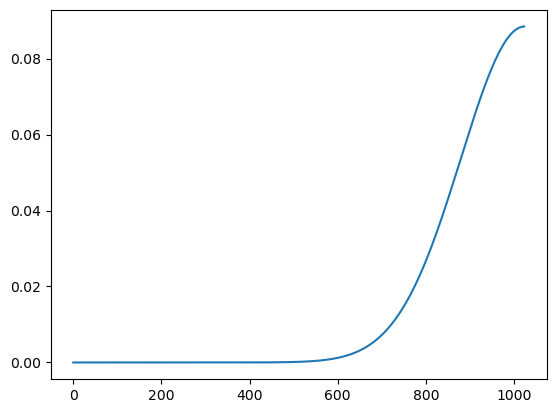

In [4]:
f1 = lambda x :  np.exp(-(x/2-0.5)**2/0.01)
df1 = lambda x: ( -(x/2-0.5)/(0.01) ) * f1(x)

m = 5
l = 2**m
x_coarse = np.linspace(0,1,l+1)
p1 = get_polys(x_coarse,f1,df1)


n = 10
N = 2**n
x = np.linspace(0, 1 - 1/N, N)

M_list1 = []
for i,p in enumerate(p1):
    reg = [i//2**_%2 for _ in range(m)[::-1]]
    M = MPS_poly(n,p,reg)
    M_list1.append(M)

M_full1 = (reduce(lambda a,b: MPS_sum(a,b),M_list1))

M_final1 = trunc_mps(M_full1,10)
plt.plot(get_state(M_final1))

In [31]:
import numpy as np
import pymanopt
from pymanopt.manifolds import Product, Stiefel
from pymanopt import Problem
from pymanopt.optimizers import ConjugateGradient, TrustRegions, NelderMead


def pymanopt_descent(initial,target,gates,indices):
    gates = [g.real for g in gates]
    manifold = Product([Stiefel(*g.shape) for g in gates])
    hist = []
    
    @pymanopt.function.autograd(manifold)
    def cost(*args):
        l = gate_infidelity_gradient(args,indices,initial,target,0)[1]
        hist.append(1-abs(l)**2)
        return (1-abs(l)**2)
    
    @pymanopt.function.autograd(manifold)
    def euclidean_gradient(*args):
        return [gate_infidelity_gradient(args,indices,initial,target,i)[0] for i in range(len(gates))]
    
    problem = Problem(manifold, cost, euclidean_gradient=euclidean_gradient)
    solver = pymanopt.optimizers.ConjugateGradient(min_step_size = 1e-10)
    result = solver.run(problem, initial_point=gates)
    return result.point, hist 

def optimize_layers_test(k,mps,reps=0,alpha=1e-3,beta1=0.9,beta2=0.999):

    grad_layers = []
    grad_opts = []
    layer_hist = []
    n = len(mps)
    psi_init = [np.array([[1,0],[0,0]])] + [np.array([[[1,0],[0,0]],[[0,0],[0,0]]])] * (n-2) + [np.array([[1,0],[0,0]])]

    for i in range(k):
        if(i==0):
            new_layer = get_layer(trunc_mps(mps,2))
            grad_layers.append(new_layer)
            
            gates,indices = layers_convert(grad_layers[::-1])

            new_gates,eps = pymanopt_descent(psi_init,mps,gates,indices)        
            new_L = gates_convert(new_gates,indices,n)
            
            grad_layers = new_L[::-1]
            layer_hist.append(deepcopy(grad_layers[::-1]))
            grad_opts.append(eps)
            
        else:
            current_mps = deepcopy(mps)
            for i in grad_layers:
                current_mps = disentangle_layer__(current_mps,i)
            
            new_layer = get_layer(trunc_mps(current_mps,2))
            grad_layers.append(new_layer)

            gates,indices = layers_convert(grad_layers[::-1])
            new_gates,eps = pymanopt_descent(psi_init,mps,gates,indices)
            
            new_L = gates_convert(new_gates,indices,n)
            
            grad_layers = new_L[::-1]
            layer_hist.append(deepcopy(grad_layers[::-1]))
            grad_opts.append(eps)
            
    grad_layers = grad_layers[::-1]

    return grad_layers, layer_hist, grad_opts


In [32]:
solve = optimize_layers_test(2,M_final1)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +1.5832699650775162e-05    6.88886793e-07    
Terminated - min grad norm reached after 1 iterations, 0.00 seconds.

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +5.7701970210821685e-06    3.67755287e-04    
   2         +5.7701970210821685e-06    3.67755287e-04    
Terminated - min step_size reached after 2 iterations, 0.14 seconds.



In [52]:
import numpy as np
import geomstats.backend as gs
from geomstats.geometry.stiefel import Stiefel
from geomstats.geometry.product_manifold import ProductManifold
from copy import deepcopy

def optimize_layers_test(k,mps,reps=0,alpha=1e-3,beta1=0.9,beta2=0.999):

    grad_layers = []
    grad_opts = []
    layer_hist = []
    n = len(mps)
    psi_init = [np.array([[1,0],[0,0]])] + [np.array([[[1,0],[0,0]],[[0,0],[0,0]]])] * (n-2) + [np.array([[1,0],[0,0]])]

    for i in range(k):
        if(i==0):
            new_layer = get_layer(trunc_mps(mps,2))
            grad_layers.append(new_layer)
            
            gates,indices = layers_convert(grad_layers[::-1])

            new_gates,eps = geomstats_descent(psi_init,mps,gates,indices)        
            new_L = gates_convert(new_gates,indices,n)
            
            grad_layers = new_L[::-1]
            layer_hist.append(deepcopy(grad_layers[::-1]))
            grad_opts.append(eps)
            
        else:
            current_mps = deepcopy(mps)
            for i in grad_layers:
                current_mps = disentangle_layer__(current_mps,i)
            
            new_layer = get_layer(trunc_mps(current_mps,2))
            grad_layers.append(new_layer)

            gates,indices = layers_convert(grad_layers[::-1])
            new_gates,eps = geomstats_descent(psi_init,mps,gates,indices)
            
            new_L = gates_convert(new_gates,indices,n)
            
            grad_layers = new_L[::-1]
            layer_hist.append(deepcopy(grad_layers[::-1]))
            grad_opts.append(eps)
            
    grad_layers = grad_layers[::-1]

    return grad_layers, layer_hist, grad_opts

def geomstats_descent(initial, target, gates, indices, max_iter=1000, lr=1e-2, tol=1e-10):
    # Convert gates to real and to geomstats format
    gates = [gs.array(g.real) for g in gates]
    
    # Create manifolds for each gate (assuming Stiefel manifold)
    manifolds = [Stiefel(n=g.shape[0], p=g.shape[1]) for g in gates]
    
    hist = []
    current_point = gates.copy()
    
    # Simple gradient descent on manifold
    for iteration in tqdm(range(max_iter)):
        # Compute cost and gradient
        l = gate_infidelity_gradient(current_point, indices, initial, target, 0)[1]
        cost_val = (1 - abs(l)**2)
        hist.append(cost_val)
        
        # Compute Euclidean gradients for each gate
        euclidean_grads = [gate_infidelity_gradient(current_point, indices, initial, target, i)[0] 
                          for i in range(len(current_point))]
        
        # Convert to Riemannian gradients and update each gate
        updated_gates = []
        for i, (gate, euclidean_grad) in enumerate(zip(current_point, euclidean_grads)):
            # Convert to geomstats arrays
            gate_gs = gs.array(gate)
            grad_gs = gs.array(euclidean_grad)
            
            # Project to tangent space (Riemannian gradient)
            riem_grad = manifolds[i].to_tangent(grad_gs, gate_gs)
            
            # Take gradient step using exponential map
            tangent_vec = -lr * riem_grad
            new_gate = manifolds[i].metric.exp(tangent_vec, gate_gs)
            
            updated_gates.append(gs.to_numpy(new_gate))
        
        current_point = updated_gates
        
        # Check convergence
        grad_norm = sum(np.linalg.norm(g) for g in euclidean_grads)
        if grad_norm < tol:
            break
    
    return current_point, hist

In [ ]:
import numpy as np
import geomstats.backend as gs
from geomstats.geometry.stiefel import Stiefel
from geomstats.geometry.product_manifold import ProductManifold
from copy import deepcopy
from tqdm import tqdm

def optimize_layers_test(k, mps, reps=0, alpha=1e-3, beta1=0.9, beta2=0.999):
    """
    Optimizes layers with ADAM-like momentum on manifolds.
    
    Parameters:
    - k: number of iterations
    - mps: matrix product state
    - reps: repetitions (unused in current implementation)
    - alpha: learning rate
    - beta1: momentum decay rate (first moment)
    - beta2: momentum decay rate (second moment)
    """
    grad_layers = []
    grad_opts = []
    layer_hist = []
    n = len(mps)
    psi_init = [np.array([[1,0],[0,0]])] + [np.array([[[1,0],[0,0]],[[0,0],[0,0]]])] * (n-2) + [np.array([[1,0],[0,0]])]

    for i in range(k):
        if(i==0):
            new_layer = get_layer(trunc_mps(mps,2))
            grad_layers.append(new_layer)
            
            gates,indices = layers_convert(grad_layers[::-1])

            new_gates,eps = geomstats_descent_momentum(psi_init, mps, gates, indices, 
                                                     lr=alpha, beta1=beta1, beta2=beta2)        
            new_L = gates_convert(new_gates,indices,n)
            
            grad_layers = new_L[::-1]
            layer_hist.append(deepcopy(grad_layers[::-1]))
            grad_opts.append(eps)
            
        else:
            current_mps = deepcopy(mps)
            for layer in grad_layers:
                current_mps = disentangle_layer__(current_mps, layer)
            
            new_layer = get_layer(trunc_mps(current_mps,2))
            grad_layers.append(new_layer)

            gates,indices = layers_convert(grad_layers[::-1])
            new_gates,eps = geomstats_descent_momentum(psi_init, mps, gates, indices,
                                                     lr=alpha, beta1=beta1, beta2=beta2)
            
            new_L = gates_convert(new_gates,indices,n)
            
            grad_layers = new_L[::-1]
            layer_hist.append(deepcopy(grad_layers[::-1]))
            grad_opts.append(eps)
            
    grad_layers = grad_layers[::-1]

    return grad_layers, layer_hist, grad_opts

def geomstats_descent_momentum(initial, target, gates, indices, max_iter=1000, lr=1e-2, 
                             beta1=0.9, beta2=0.999, epsilon=1e-8, tol=1e-10):
    """
    ADAM-like optimizer for Riemannian manifolds with momentum.
    
    Parameters:
    - initial, target, gates, indices: problem-specific parameters
    - max_iter: maximum iterations
    - lr: learning rate
    - beta1: exponential decay rate for first moment estimates
    - beta2: exponential decay rate for second moment estimates  
    - epsilon: small constant for numerical stability
    - tol: convergence tolerance
    """
    # Convert gates to real and to geomstats format
    gates = [gs.array(g.real) for g in gates]
    
    # Create manifolds for each gate (assuming Stiefel manifold)
    manifolds = [Stiefel(n=g.shape[0], p=g.shape[1]) for g in gates]
    
    hist = []
    current_point = gates.copy()
    
    # Initialize momentum terms for each gate
    m = [gs.zeros_like(gate) for gate in gates]  # First moment (momentum)
    v = [gs.zeros_like(gate) for gate in gates]  # Second moment (RMSprop-like)
    
    for iteration in tqdm(range(max_iter)):
        # Compute cost and gradient
        l = gate_infidelity_gradient(current_point, indices, initial, target, 0)[1]
        cost_val = (1 - abs(l)**2)
        hist.append(cost_val)
        
        # Compute Euclidean gradients for each gate
        euclidean_grads = [gate_infidelity_gradient(current_point, indices, initial, target, i)[0] 
                          for i in range(len(current_point))]
        
        # Update each gate with ADAM-like momentum
        updated_gates = []
        for i, (gate, euclidean_grad) in enumerate(zip(current_point, euclidean_grads)):
            # Convert to geomstats arrays
            gate_gs = gs.array(gate)
            grad_gs = gs.array(euclidean_grad)
            
            # Project to tangent space (Riemannian gradient)
            riem_grad = manifolds[i].to_tangent(grad_gs, gate_gs)
            
            # Update momentum terms
            # First moment (exponential moving average of gradients)
            m[i] = beta1 * m[i] + (1 - beta1) * riem_grad
            
            # Second moment (exponential moving average of squared gradients)
            v[i] = beta2 * v[i] + (1 - beta2) * gs.power(riem_grad, 2)
            
            # Bias correction
            m_hat = m[i] / (1 - beta1**(iteration + 1))
            v_hat = v[i] / (1 - beta2**(iteration + 1))
            
            # ADAM update in tangent space
            tangent_vec = -lr * m_hat / (gs.sqrt(v_hat) + epsilon)
            
            # Map back to manifold using exponential map
            new_gate = manifolds[i].metric.exp(tangent_vec, gate_gs)
            
            updated_gates.append(gs.to_numpy(new_gate))
        
        current_point = updated_gates
        
        # Check convergence
        grad_norm = sum(np.linalg.norm(g) for g in euclidean_grads)
        if grad_norm < tol:
            break
    
    return current_point, hist

def geomstats_descent(initial, target, gates, indices, max_iter=1000, lr=1e-2, tol=1e-10):
    """
    Original gradient descent function (kept for backward compatibility)
    """
    # Convert gates to real and to geomstats format
    gates = [gs.array(g.real) for g in gates]
    
    # Create manifolds for each gate (assuming Stiefel manifold)
    manifolds = [Stiefel(n=g.shape[0], p=g.shape[1]) for g in gates]
    
    hist = []
    current_point = gates.copy()
    
    # Simple gradient descent on manifold
    for iteration in tqdm(range(max_iter)):
        # Compute cost and gradient
        l = gate_infidelity_gradient(current_point, indices, initial, target, 0)[1]
        cost_val = (1 - abs(l)**2)
        hist.append(cost_val)
        
        # Compute Euclidean gradients for each gate
        euclidean_grads = [gate_infidelity_gradient(current_point, indices, initial, target, i)[0] 
                          for i in range(len(current_point))]
        
        # Convert to Riemannian gradients and update each gate
        updated_gates = []
        for i, (gate, euclidean_grad) in enumerate(zip(current_point, euclidean_grads)):
            # Convert to geomstats arrays
            gate_gs = gs.array(gate)
            grad_gs = gs.array(euclidean_grad)
            
            # Project to tangent space (Riemannian gradient)
            riem_grad = manifolds[i].to_tangent(grad_gs, gate_gs)
            
            # Take gradient step using exponential map
            tangent_vec = -lr * riem_grad
            new_gate = manifolds[i].metric.exp(tangent_vec, gate_gs)
            
            updated_gates.append(gs.to_numpy(new_gate))
        
        current_point = updated_gates
        
        # Check convergence
        grad_norm = sum(np.linalg.norm(g) for g in euclidean_grads)
        if grad_norm < tol:
            break
    
    return current_point, hist

In [56]:
solve = optimize_layers_test(2,M_final1)

100%|██████████| 1000/1000 [01:16<00:00, 13.02it/s]


C:\Users\bik19\AppData\Local\Temp\ipykernel_1452\1788973460.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(o),label=f'Layer {i}')


Text(0, 0.5, 'Log Infidelity')

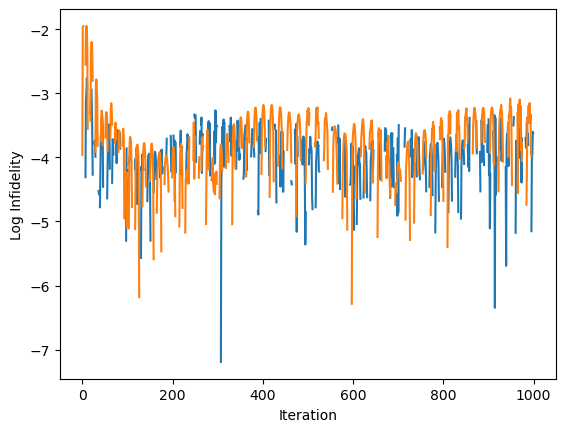

In [57]:
for o in solve[-1]:   
    plt.plot(np.log10(o),label=f'Layer {i}')
plt.xlabel('Iteration')
plt.ylabel('Log Infidelity')